In [126]:
%pip install plotly pandas pyspark

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%spark-shell` not found.


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count
import plotly.express as px

# Conectando com o banco

spark = SparkSession.builder \
    .appName("PGconection") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.6.0") \
    .getOrCreate()

url = "jdbc:postgresql://localhost:5432/aurora"
tabela = "sensores"

propriedades = {
    "user": "admin",
    "password": "admin",
    "driver": "org.postgresql.Driver"
}

# Obtendo sensores por cidade

sensors_df = spark.read.jdbc(url=url, table="sensores", properties=propriedades)

print("Sensores por cidade")
sensors_df.groupBy("cidade").agg(count("*").alias("total")).show()

# obtendo eventos de jam por cidade

events_df = spark.read.jdbc(url=url, table="eventos", properties=propriedades)

print("Eventos de jam_signal por cidade")
(
    events_df.where(events_df["tipo"] == "jam_signal")
    .groupBy("cidade")
    .agg(count("*").alias("total"))
    .orderBy("total", ascending=False)
    .show()
)

# Eventos por hora

eventos_por_hora = events_df.groupBy("hora").agg(count("*").alias("total"))

eventos_por_hora_pd = eventos_por_hora.orderBy("hora").toPandas()

fig = px.bar(
    eventos_por_hora_pd,
    x="hora",
    y="total",
    labels={"hora": "Hora do Dia", "total": "Qtd de Eventos"},
    title="Histograma de Eventos por Hora"
)

fig.show()

spark.stop()



25/05/19 23:49:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Sensores por cidade


+---------+-----+
|   cidade|total|
+---------+-----+
|Podgorica|   17|
| Sarajevo|   12|
| Pristina|   19|
|   Tirana|   18|
|   Skopje|   16|
+---------+-----+

Eventos de jam_signal por cidade
+---------+-----+
|   cidade|total|
+---------+-----+
|   Skopje|  458|
|   Tirana|  167|
| Pristina|  155|
|Podgorica|  136|
| Sarajevo|  102|
+---------+-----+



Existem no total 82 sensores em 5 cidades.

Já os eventos de jam_signal são distribuídos da seguinte forma:

Skopje,  458
Tirana,  167
Pristina,  155
Podgorica,  136
Sarajevo,  102

onde Skopje é a cidade com mais eventos de jam_signal


In [49]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, sum, col
import plotly.express as px

spark = SparkSession.builder \
    .appName("CSV") \
    .config("spark.jars", "drivers/postgresql-42.7.3.jar") \
    .getOrCreate()

logs_df = spark.read.csv("data/logs.csv", header=True)

# Filtrando por horário (01h–04h)

filtered_df = logs_df.filter(
    (col("hora") >= "01:00") & (col("hora") <= "04:00")
)

# calculando volume total por cidade

result = filtered_df.groupBy("cidade") \
    .agg(sum("volume_transmitido_mb").alias("volume_total_mb")) \
    .orderBy(col("volume_total_mb").desc())

print("Volume total por cidade entre 01h-04h:")
result.show()

# calculando volume médio por cidade

result = filtered_df.groupBy("cidade") \
    .agg(avg("volume_transmitido_mb").alias("volume_medio_mb")) \
    .orderBy(col("volume_medio_mb").desc())

print("Volume médio por cidade entre 01h-04h:")

# Plotando média de volume por cidade

volume_medio_pd = result.toPandas()

fig = px.bar(
    volume_medio_pd,
    x="cidade",
    y="volume_medio_mb",
    labels={"cidade": "Cidade", "volume_medio_mb": "Volume Médio (MB)"},
    title="Volume Médio Transmitido por Cidade (01h–04h)",
)

fig.show()
spark.stop()

25/05/19 17:05:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Volume total por cidade entre 01h-04h:
+---------+------------------+
|   cidade|   volume_total_mb|
+---------+------------------+
|   Skopje| 3020.070000000001|
| Pristina| 1834.919999999999|
|   Tirana|1548.9099999999999|
|Podgorica|1181.0900000000004|
| Sarajevo|1129.9700000000003|
+---------+------------------+

Volume médio por cidade entre 01h-04h:


Enquanto a cidade com o maior volume médio é Pristina, a com o maior volume bruto é Skopje

25/05/19 22:47:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


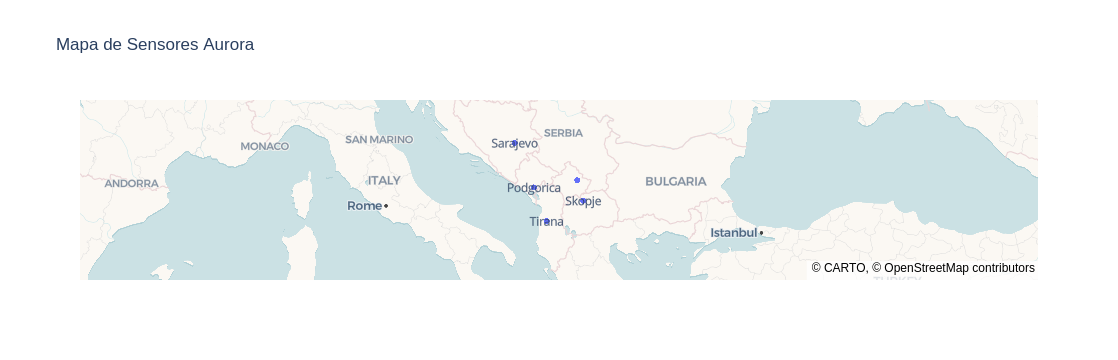

In [136]:
from pyspark.sql import SparkSession
import plotly.express as px

spark = SparkSession.builder \
    .appName("CSV") \
    .getOrCreate()

logs_df = spark.read.csv("data/logs.csv", header=True)
location_df = spark.read.csv("data/coordenadas.csv", header=True)

# Renomeando para evitar conflito
logs_df = logs_df.withColumnRenamed("cidade", "cidade_df1")

logs_location_df = logs_df.join(location_df, logs_df.cidade_df1 == location_df.cidade, "inner")
logs_location_df.drop("cidade_df1")

logs_location_df = logs_location_df.withColumn("latitude", col("latitude").cast("double")) \
                  .withColumn("longitude", col("longitude").cast("double"))

pandas_df = logs_location_df.toPandas()

fig = px.scatter_map(
    pandas_df,
    text='cidade',
    lat='latitude',
    lon='longitude',
    size_max=30,
    zoom=4,
    title='Mapa de Sensores Aurora'
)

fig.show()

spark.stop()

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc
import pandas as pd
import plotly.express as px

spark = SparkSession.builder \
    .appName("Read from MongoDB") \
    .config("spark.mongodb.read.database", "test") \
    .config("spark.mongodb.read.collection", "meteo") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.5.0") \
    .getOrCreate()

df = spark.read.format("mongodb").load()

max_magnetic = df.orderBy(desc("campo_magnetico_microtesla")).first()
print(f"Cidade com maior campo magnético: {max_magnetic['cidade']} com {max_magnetic['campo_magnetico_microtesla']} µT")

high_magnetic = df.filter(col("campo_magnetico_microtesla") > 65).count()
print(f"\nRegistros com campo magnético > 65 µT: {high_magnetic}")

# Top 3 cidades com mais registros
top_cities = df.groupBy("cidade").count().orderBy(desc("count")).limit(3).collect()
top_city_names = [row['cidade'] for row in top_cities]

# Preparar dados para o gráfico
plot_df = df.filter(col("cidade").isin(top_city_names)).orderBy("timestamp")
plot_df = plot_df.toPandas()
plot_df['timestamp'] = pd.to_datetime(plot_df['timestamp'])

# Criar gráfico de linha do tempo
fig = px.line(plot_df,
              x='timestamp',
              y='campo_magnetico_microtesla',
              color='cidade',
              title='Campo Magnético ao Longo do Tempo (Top 3 Cidades)',
              labels={'timestamp': 'Data/Hora',
                      'campo_magnetico_microtesla': 'Campo Magnético (µT)',
                      'cidade': 'Cidade'})
fig.show()

spark.stop()


25/05/19 23:36:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Cidade com maior campo magnético: Tirana com 76.89 µT

Registros com campo magnético > 65 µT: 149


In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Analise Integrada") \
    .config("spark.mongodb.read.database", "test") \
    .config("spark.mongodb.read.collection", "meteo") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.5.0,org.postgresql:postgresql:42.6.0") \
    .getOrCreate()

mongo_df = spark.read.format("mongodb").load()
logs_df = spark.read.csv("data/logs.csv", header=True)

url = "jdbc:postgresql://localhost:5432/aurora"
propriedades = {
    "user": "admin",
    "password": "admin",
    "driver": "org.postgresql.Driver"
}
events_df = spark.read.jdbc(url=url, table="eventos", properties=propriedades)

25/05/19 23:47:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [9]:
from pyspark.sql.functions import col, avg, count, hour
import plotly.express as px

# Agregando por cidade

mag_field = mongo_df.filter((hour(col("timestamp")) >= 1) & (hour(col("timestamp")) <= 4)) \
    .groupBy("cidade") \
    .agg(avg("campo_magnetico_microtesla").alias("campo_mag_medio"))


volume = logs_df.filter((col("hora") >= "01:00") & (col("hora") <= "04:00")) \
    .groupBy("cidade") \
    .agg(avg("volume_transmitido_mb").alias("volume_medio"))

# 3. Contagem de eventos jam_signal (1h-4h)
events = events_df.filter((col("hora") >= "01:00") & (col("hora") <= "04:00")) \
    .filter(col("tipo") == "jam_signal") \
    .groupBy("cidade") \
    .agg(count("*").alias("jam_count"))

final_df = mag_field.join(volume, "cidade") \
    .join(events, "cidade") \
    .toPandas()

# Plotando
fig = px.scatter(final_df,
                 x="campo_mag_medio",
                 y="volume_medio",
                 color="cidade",
                 size="jam_count",
                 title="Correlação: Campo Magnético vs Volume Transmitido",
                 labels={
                     "campo_mag_medio": "Campo Magnético Médio (µT)",
                     "volume_medio": "Volume Médio (MB)",
                     "jam_count": "Qtd. Eventos Jam"
                 })
fig.show()

spark.stop()


Sim, Skopje está de fato no centro da Operação Aurora. Nas primeiras análises, não se pode afirmar muita coisa: o histograma de eventos por hora não segue nenhum tipo de curva ou distribuição clara. A maior média de transmissão aponta para Pristina e Tirana; entretanto, o volume total transferido para Skopje é massivo, ultrapassando o segundo colocado em quase 100%, o que indica fortemente que toda a informação está sendo centralizada na cidade.

Também é possível observar que a quantidade de eventos do tipo jam_signal é massivamente maior na região, o que pode indicar que algum tipo de conexão de rádio está sendo bloqueada por motivos estratégicos. Ao que tudo indica, regiões com anomalias estão sendo constantemente monitoradas, e as informações podem estar sendo concentradas em Skopje.

Link para o repositório do github: https://github.com/MateusGurgel/Infnet-Works/tree/main/creation_of_big_data_solutions_with_spark/tp-2